<a href="https://colab.research.google.com/github/Bakarime27/olist-project/blob/main/stabilite_olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Segmentez des clients d'un site e-commerce**
Ce projet a pour but d'effectuer une segmentation des clients d'Olist (un site d'e-commerce) afin que ses équipes marketing puissent s'en servir dans leurs campagnes de communication.

Notre mission est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons fournir une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous allons également fournir une analyse de la stabilité des segments au cours du temps afin d'établir un contrat de maintenance.

### **1.&nbsp;Stabilité de la segmentation**

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.  
Pour cela, nous devons recréer le dataset et recalculer toutes les features en fonction d'une période donnée

In [ ]:
from google.colab import drive
#drive.mount("/gdrive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Datasets
%ls

Mounted at /gdrive
/gdrive/MyDrive/Datasets
2016_Building_Energy_Benchmarking.csv  olist_order_payments_dataset.csv
clean-data.csv                         olist_order_reviews_dataset.csv
fr.openfoodfacts.org.products.csv      olist_orders_dataset.csv
house.csv                              olist_products_dataset.csv
olist_customers_dataset.csv            olist-rfm.csv
olist-customers-segmentation.csv       olist_sellers_dataset.csv
olist_geolocation_dataset.csv          product_category_name_translation.csv
olist_order_items_dataset.csv          sea-clean-data.csv


In [ ]:
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from datetime import datetime
from datetime import timedelta
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
#from kmodes.kprototypes import KPrototypes
from math import radians, cos, sin, asin, sqrt

### **1.1.&nbsp;Création de dataset**

Nous allons retenir que les articles qui ont livrés

In [ ]:
orders = pd.read_csv("olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered",
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)

In [ ]:
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


**Définition des focntions**

In [ ]:
def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956 # rayon de la Terre en miles

    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])

    # Formule Haversine
    dlng = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))

    return d

In [ ]:
def make_dataset(initial=False, period=60, delai=1):
    """Cleaning and feature engineering on complete Olist data
        for preparation of unsupervised classification (K-Means).

    Parameters
    ----------
    initial : booléen
        Défini si le dataset est le dataset initial.
    period : int
        Nombre de semaines depuis le début de dataset jusqu'à la fin de la période
    délai : int
        Période incrémenté en semaine après le dataset initial.
    """
    start_time = time()
    print("Création du dataset ...")

    print("Chargement des données ...")
    # Load datasets
    customers = pd.read_csv("olist_customers_dataset.csv")
    geolocations = pd.read_csv("olist_geolocation_dataset.csv")
    orders = pd.read_csv("olist_orders_dataset.csv")
    order_items = pd.read_csv("olist_order_items_dataset.csv")
    order_payments = pd.read_csv("olist_order_payments_dataset.csv")
    order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
    products = pd.read_csv("olist_products_dataset.csv")
    categories_en = pd.read_csv("product_category_name_translation.csv")
    #rfm = pd.read_csv("olist-rfm.csv")

    print("Fin du chargement des données")

    print("Création des jointures ...")
    # Group location
    geolocations = geolocations.groupby(["geolocation_state"]).agg({
            "geolocation_lat": "mean",
            "geolocation_lng": "mean"})

    # Merge datasets
    # Orders
    orders.drop(["order_delivered_carrier_date",
                 "order_estimated_delivery_date"],
                axis=1, inplace=True)

    order_items.drop(["seller_id",
                      "shipping_limit_date"],
                     axis=1, inplace=True)


    order_items_joint = pd.merge(orders, order_items,
                           how="left",
                           on="order_id")


    order_items_joint = order_items_joint[order_items_joint.order_status == "delivered"]

    datetime_cols = ["order_purchase_timestamp",
                     "order_delivered_customer_date"]
    for col in datetime_cols:
        order_items_joint[col] = order_items_joint[col].astype('datetime64[ns]')

    # order Month
    order_items_joint["sale_month"] = order_items_joint['order_purchase_timestamp'].dt.month

    # Select orders on period
    start=order_items_joint["order_purchase_timestamp"].min()
    if(initial == True):
        mois = period
    else:
        mois = period + delai
    stop=start + pd.DateOffset(weeks=int(mois))

    order_items_joint = order_items_joint[(order_items_joint["order_purchase_timestamp"]>=start)
                              & (order_items_joint["order_purchase_timestamp"]<stop)]


    # List of orders on period
    period_orders = order_items_joint.order_id.unique()

    # Calculate other features on period

    #payments
    #order_payments = order_payments[order_payments["order_id"].isin(period_orders)]
    order_items_payments = pd.merge(order_items_joint, order_payments.groupby(by="order_id").agg(
                               {"payment_sequential": 'count',
                                "payment_installments": 'sum',
                                "payment_value":'sum'}),
                           how="left",
                           on="order_id")
    order_items_payments = order_items_payments.rename(columns={
        "payment_sequential": "nb_payment_sequential",
        "payment_installments": "sum_payment_installments",
        "payment_value": "sum_payment_value"})


    #reviews
    #order_reviews = order_reviews[order_reviews["order_id"].isin(period_orders)]
    order_items_payments_reviews = pd.merge(order_items_payments,
                           order_reviews.groupby("order_id").agg({
                               "review_score": "mean",
                               "review_id": "count"}),
                           how="left",
                           on="order_id")
    order_items_payments_reviews = order_items_payments_reviews.rename(columns={
        "review_id": "is_reviewed"})


    # Customers
    order_items_payments_reviews_customers = pd.merge(order_items_payments_reviews, customers,
                           on="customer_id",
                           how="left")


    # Products
    products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

    del_features_list = ["product_category_name", "product_weight_g",
                         "product_length_cm", "product_height_cm",
                         "product_width_cm", "product_name_lenght",
                         "product_description_lenght", "product_photos_qty"]
    products.drop(del_features_list, axis=1, inplace=True)
    products = products.rename(columns={"product_category_name_english":
                                        "product_category_name"})

    products['product_category'] = np.where((products['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                            np.where((products['product_category_name'].str.contains("health|beauty|perfum")==True),
                                     'health_beauty',
                            np.where((products['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                            np.where((products['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                            np.where((products['product_category_name'].str.contains("grocer|food|drink")==True),
                                     'groceries_food_drink',
                            np.where((products['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True),
                                     'technology',
                            np.where((products['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True),
                                     'home_furniture',
                            np.where((products['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                            np.where((products['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))
    products.drop("product_category_name", axis=1, inplace=True)

    #All joints

    order_items_payments_reviews_customers_products = pd.merge(order_items_payments_reviews_customers, products,
                           how="left",
                           on="product_id")


     # Delivery time
    order_items_payments_reviews_customers_products["delivery_delta_days"] = (order_items_payments_reviews_customers_products.order_delivered_customer_date
                                          - order_items_payments_reviews_customers_products.order_purchase_timestamp)\
                                         .dt.round('1d').dt.days
    order_items_payments_reviews_customers_products.drop("order_delivered_customer_date", axis=1, inplace=True)

    categories_customers = order_items_payments_reviews_customers_products.groupby(["customer_unique_id", "product_category"])\
                        .agg({"order_item_id": "count"}).unstack()
    categories_customers.columns = categories_customers.columns.droplevel(0)
    categories_customers.fillna(0, inplace=True)
    categories_customers["total_items"] = categories_customers.sum(axis=1)

    for col in categories_customers.columns:
        if (col != "total_items"):
            categories_customers[col] = (categories_customers[col]/categories_customers["total_items"])

    categories_customers.reset_index(inplace=True)

    products_per_order = order_items_payments_reviews_customers_products.groupby(["customer_unique_id", "order_id"])\
                        .agg({"order_item_id": "count"})
    products_per_order = products_per_order.groupby("customer_unique_id")\
                        .agg({"order_item_id": "mean"})

    recurencies = order_items_payments_reviews_customers_products.groupby("customer_unique_id")\
                .agg({"order_purchase_timestamp": ["min","max"]})
    recurencies.columns = recurencies.columns.droplevel(0)

    # Max date in dataset
    max_date_ = order_items_payments_reviews_customers_products["order_purchase_timestamp"].max()

    # Delay from the last order
    recurencies["order_total_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                    else (max_date_ - y[0]).round('1d').days
                                    for x,y in recurencies.iterrows()]
    recurencies.drop(["min", "max"], axis=1, inplace=True)

    max_date = order_items_payments_reviews_customers_products.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
    max_date = max_date.rename({'order_purchase_timestamp':'most_recent'},axis = 1)
    max_date['r_score'] = (max_date['most_recent'].max() - max_date['most_recent']).dt.days

    n_transaction = order_items_payments_reviews_customers_products.groupby('customer_unique_id')['order_id'].count().reset_index()
    n_transaction = n_transaction.rename({'order_id':'f_score'},axis = 1)

    avg_purchase = order_items_payments_reviews_customers_products.groupby('customer_unique_id')['sum_payment_value'].mean().reset_index()
    avg_purchase = avg_purchase.rename({'sum_payment_value':'m_score'},axis = 1)

    df_rf = max_date.merge(n_transaction, how = 'left', on = 'customer_unique_id')
    df_rfm = df_rf.merge(avg_purchase, how = 'left', on = 'customer_unique_id')
    df_rfm = df_rfm[['customer_unique_id','r_score','f_score','m_score']]

    print("Fin de la création des jointures")

    print("Création de la jointure globale ...")

    data = order_items_payments_reviews_customers_products.groupby("customer_unique_id")\
                      .agg({"order_id": "nunique",
                            "price": "sum",
                            "freight_value": "sum",
                            "nb_payment_sequential": "mean",
                            "sum_payment_installments": "mean",
                            "review_score": "mean",
                            "delivery_delta_days": "mean",
                            "sale_month": lambda x:x.value_counts()})
    data = data.rename(columns={"order_id": "nb_orders",
                            "price": "total_spend",
                            "freight_value": "total_freight",
                            "nb_payment_sequential": "mean_payment_sequential",
                            "sum_payment_installments": "mean_payment_installments",
                            "review_score": "mean_review_score",
                            "delivery_delta_days": "mean_delivery_days",
                            "sale_month": "favorite_sale_month"})

    data = pd.merge(data, categories_customers,
                how="left",
                on="customer_unique_id")

    data = pd.merge(data, products_per_order,
                how="left",
                on="customer_unique_id")\
        .rename(columns={"order_item_id": "mean_nb_items"})

    data = pd.merge(data, recurencies,
                how="left",
                on="customer_unique_id")
    data = data.merge(df_rfm, how = 'left', on = 'customer_unique_id')

    data["order_total_delay"] = data["order_total_delay"] / data["nb_orders"]
    data = data.rename(columns={"order_total_delay": "order_mean_delay"})

    ''' # Mean delay between 2 orders
    data["order_mean_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                else (stop - y[0]).round('1d').days
                                for x,y in data[["first_order","last_order"]].iterrows()]
    data["order_mean_delay"] = data["order_mean_delay"] / data["nb_orders"]
    data.drop(["first_order", "last_order"], axis=1, inplace=True) '''

    # Freight ratio and total price
    data["freight_ratio"] = (round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2))
    data["total_spend"] = (data["total_spend"] + data["total_freight"])
    data["mean_price_order"] = (round(data["total_spend"] / data["nb_orders"],2))
    data.drop("total_freight", axis=1, inplace=True)

    customers_info = customers.groupby("customer_unique_id").agg(lambda x:x.value_counts().index[0])
    data = pd.merge(data, customers_info,
                how="left",
                on="customer_unique_id")

    # Add Haversine distance of customer state
    # Haversine distance
    olist_lat = -25.43045
    olist_lon = -49.29207

    geolocations['haversine_distance'] = [haversine_distance(olist_lat, olist_lon, x, y)
                                         for x, y in zip(geolocations.geolocation_lat,
                                                         geolocations.geolocation_lng)]
    data = pd.merge(data.reset_index(), geolocations[["haversine_distance"]],
                    how="left",
                    left_on="customer_state",
                    right_on="geolocation_state")
    data.drop(["customer_state"], axis=1, inplace=True)
    data.set_index("customer_unique_id", inplace=True)
    data.drop(["index"], axis=1, inplace=True)

    # complete missing values
    features_to_fill = data.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)

    print(54*"_")
    print("Features complétées avec la valeur la plus fréquente :")
    print(54*"_")
    for f in features_to_fill:
        data[f] = data[f].fillna(data[f].mode()[0])
        print(f,"\t", data[f].mode()[0])
    print(54*"_")

    end_time = time()
    print("Durée d'execution du Feature engineering : {:.2f}s".format(end_time - start_time))

    return data

In [ ]:
data_init = make_dataset(initial=True)

Création du dataset ...
Chargement des données ...
Fin du chargement des données
Création des jointures ...
Fin de la création des jointures
Création de la jointure globale ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
m_score 	 77.57
______________________________________________________
Durée d'execution du Feature engineering : 158.31s


In [ ]:
data_init.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31112 entries, 0000f46a3911fa3c0805444483337064 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   nb_orders                     31112 non-null  int64  
 1   total_spend                   31112 non-null  float64
 2   mean_payment_sequential       31112 non-null  float64
 3   mean_payment_installments     31112 non-null  float64
 4   mean_review_score             31112 non-null  float64
 5   mean_delivery_days            31112 non-null  float64
 6   favorite_sale_month           31112 non-null  object 
 7   books_cds_media               31112 non-null  float64
 8   fashion_clothing_accessories  31112 non-null  float64
 9   flowers_gifts                 31112 non-null  float64
 10  groceries_food_drink          31112 non-null  float64
 11  health_beauty                 31112 non-null  float64
 12  home_fu

In [ ]:
data_init.head()

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,...,order_mean_delay,r_score,f_score,m_score,freight_ratio,mean_price_order,customer_id,customer_zip_code_prefix,customer_city,haversine_distance
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,1,0.0,0.0,0.0,...,244.0,243,1,86.22,0.20,86.22,9b3932a6253894a02c1df9d19004239f,88115,sao jose,125.363853
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,1,0.0,0.0,0.0,...,28.0,27,1,43.62,0.40,43.62,914991f0c02ef0843c0e7010c819d642,66812,belem,1574.231129
0005e1862207bf6ccc02e4228effd9a0,1,150.12,1.0,3.0,4.0,4.0,1,0.0,1.0,0.0,...,250.0,249,1,150.12,0.10,150.12,3b37fb626fdf46cd99d37ec62afa88ff,25966,teresopolis,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,29.00,1.0,2.0,3.0,16.0,1,0.0,0.0,0.0,...,114.0,114,1,29.00,0.52,29.00,2f29573c8cac5a7be11c5b649078f944,29400,mimoso do sul,669.215559
000a5ad9c4601d2bbdd9ed765d5213b3,1,91.28,1.0,3.0,4.0,11.0,1,0.0,0.0,0.0,...,90.0,89,1,91.28,0.16,91.28,be22f11baf346059cbe6556ef9c69070,90560,porto alegre,337.899660


In [ ]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'health_beauty',
                  'other',
                  'sport',
                  'technology',
                  'groceries_food_drink',
                  'home_furniture',
                  'toys_baby']

In [ ]:
data_init.drop(categories_col, axis=1, inplace=True)

In [ ]:
''' def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):

    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1

    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))

    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1

    # Set best K
    K = KBest
    model.set_params(n_clusters=K)
    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()

    return K
    plt.show() '''

' def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):\n    \n    if((elbow==True) & (mds==True)):\n        ncols=3\n    elif((elbow==False) | (mds==False)):\n        ncols=2\n    else:\n        ncols=1\n        \n    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))\n    \n    ax=0\n    if(elbow==True):\n        # Elbow visualizer\n        kmeans_visualizer = Pipeline([\n            ("preprocessor", preprocessor),\n            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])\n        kmeans_visualizer.fit(data)\n        KBest = kmeans_visualizer.named_steps[\'kelbowvisualizer\'].elbow_value_\n        kmeans_visualizer.named_steps[\'kelbowvisualizer\'].finalize()\n        ax+=1\n    \n    # Set best K\n    K = KBest\n    model.set_params(n_clusters=K)\n    # Silhouette Visualizer\n    silhouette_visualizer = Pipeline([\n        ("preprocessor", preprocessor),\n        ("si

In [ ]:
numerical_features = list(data_init.select_dtypes(include=['int64','float64', 'uint8']).columns)
numerical_features

['nb_orders',
 'total_spend',
 'mean_payment_sequential',
 'mean_payment_installments',
 'mean_review_score',
 'mean_delivery_days',
 'total_items',
 'mean_nb_items',
 'order_mean_delay',
 'r_score',
 'f_score',
 'm_score',
 'freight_ratio',
 'mean_price_order',
 'customer_zip_code_prefix',
 'haversine_distance']

In [ ]:
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

In [ ]:
''' K = clustering_eval(preprocessor=preprocessor,
                model=KMeans(),
                data=data_init,
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None) '''

' K = clustering_eval(preprocessor=preprocessor, \n                model=KMeans(), \n                data=data_init, \n                metric="distortion",\n                elbow=True,\n                mds=False,\n                KBest=None) '

**Explication de la méthode**

In [ ]:
K=4
kmeans_init = Pipeline([("preprocessor", preprocessor),
                        ("kmeans", KMeans(K))])
kmeans_init.fit(data_init)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['nb_orders', 'total_spend',
                                                   'mean_payment_sequential',
                                                   'mean_payment_installments',
                                                   'mean_review_score',
                                                   'mean_delivery_days',
                                                   'total_items',
                                                   'mean_nb_items',
                                                   'order_mean_delay',
                                                   'r_score', 'f_score',
                                                   'm_score', 'freight_ratio',
                                                   'mean_price_order',
                                                   'customer_zip_code_prefix',
  

In [ ]:
ari = []
for d in np.arange(1,52,1):
    # Create dataset for period
    data_d = make_dataset(initial=False, delai=d)
    data_d.drop(categories_col, axis=1, inplace=True)

    # Filter on initial customer client
    #data_d = data_d[data_d.index.isin(data_init.index)]

    # K-Means
    kmeans_d = Pipeline([("preprocessor", preprocessor),
                        ("kmeans", KMeans(K))])
    kmeans_d.fit(data_d)
    d_labels = kmeans_d.named_steps['kmeans'].labels_
    d_init_labels = kmeans_init.predict(data_d)

    # Calculate ARI score
    ari_d = adjusted_rand_score(d_init_labels, d_labels) #
    ari.append([d,ari_d])

Création du dataset ...
Chargement des données ...
Fin du chargement des données
Création des jointures ...
Fin de la création des jointures
Création de la jointure globale ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
m_score 	 77.57
______________________________________________________
Durée d'execution du Feature engineering : 152.76s
Création du dataset ...
Chargement des données ...
Fin du chargement des données
Création des jointures ...
Fin de la création des jointures
Création de la jointure globale ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5

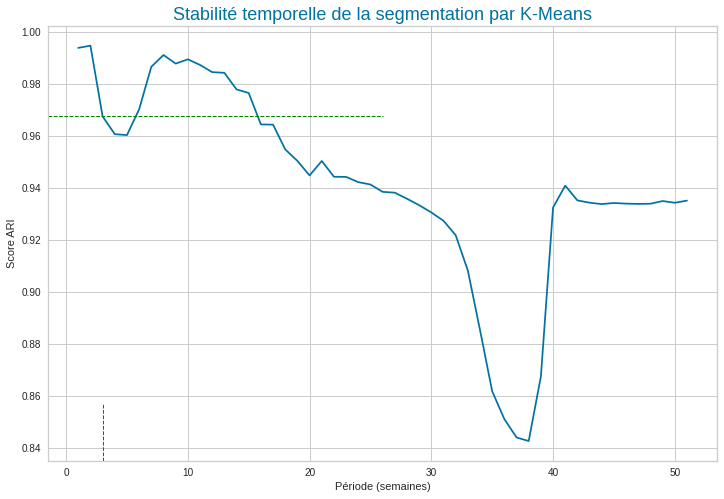

In [ ]:
ari = pd.DataFrame(ari, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari, x="periode", y="ARI")
plt.axhline(y=ari.iloc[2][1], linestyle="--",
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari.iloc[2][0], linestyle="--",
            color="green",
            ymax=1.1-(ari.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (semaines)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.savefig("../images/olist/stabilité-temporelle.png")
plt.show()

Un entrainement du modèle tous les 8-9 mois est requis